Processing files:   0%|                                   | 0/3 [02:01<?, ?it/s]


KeyboardInterrupt: 

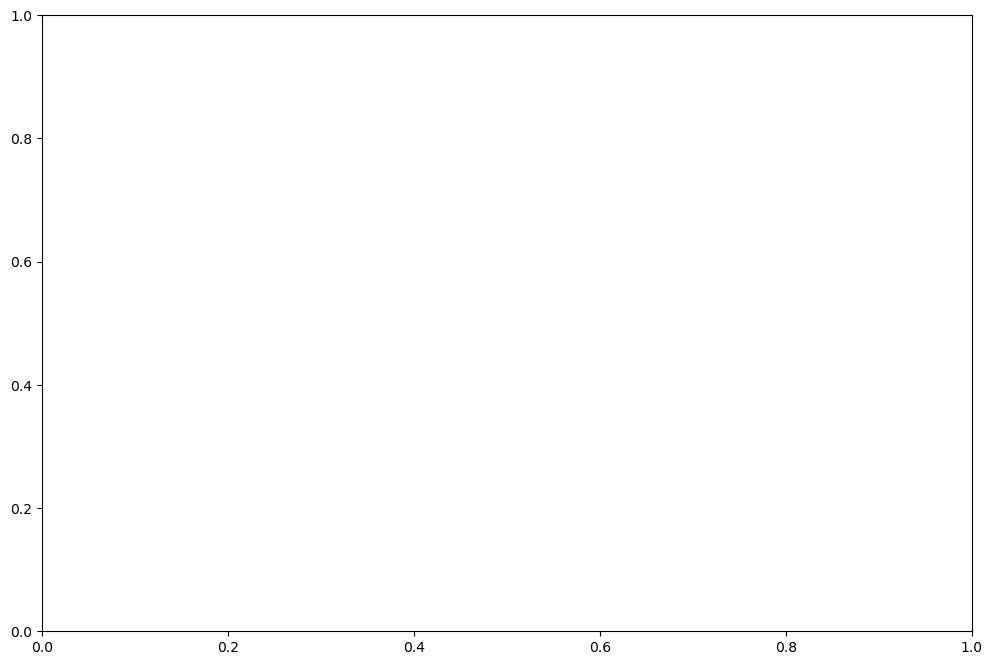

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# File paths
scenery_folder = '../../data/processed/landscape_color_features'
ratings_folder = '../../data/processed/landscape_score'

# Define score intervals
bins = [1, 2, 3, 4, 5, 6, 7]
labels = ["1-2", "2-3", "3-4", "4-5", "5-6", "6-7"]

# Get list of files
ratings_files = [f for f in os.listdir(ratings_folder) if f.startswith("processed_ns6_clean_") and f.endswith(".csv")]
scenery_files = [f.replace("processed_", "") for f in ratings_files]

# List to store merged data frames
merged_data_list = []

try:
    # Process files
    for ratings_file, scenery_file in tqdm(zip(ratings_files, scenery_files), total=len(ratings_files), desc="Processing Files"):
        # Read ratings and color feature files
        ratings_data = pd.read_csv(os.path.join(ratings_folder, ratings_file))
        scenery_data = pd.read_csv(os.path.join(scenery_folder, scenery_file))
        
        # Standardize image paths by removing the root part
        ratings_data['image_path'] = ratings_data['image_path'].apply(lambda x: x.split("data/processed/wikimedia_commons/images/")[-1])
        scenery_data['image_path'] = scenery_data['image_path'].apply(lambda x: x.split("data/processed/wikimedia_commons/images/")[-1])
        
        # Assign score categories based on predicted_score
        ratings_data['score_category'] = pd.cut(ratings_data['predicted_score'], bins=bins, labels=labels, right=False)
        
        # Merge ratings and color feature data on standardized image path
        df_merged = pd.merge(ratings_data[['image_path', 'score_category', 'predicted_score']], scenery_data, left_on='image_path', right_on='image_path', how='inner')
        
        # Add to the list of dataframes
        merged_data_list.append(df_merged)

    # Concatenate all dataframes
    merged_df = pd.concat(merged_data_list, ignore_index=True)
    
    # Specify color feature columns
    color_features = ['H_mean', 'S_mean', 'V_mean', 'I1_mean', 'I2_mean', 'I3_mean', 'L_mean', 'S_lst_mean', 'T_mean']

    # Plot each color space with a regression line (without scatter points)
    hsv_features = ['H_mean', 'S_mean', 'V_mean']
    oathe_features = ['I1_mean', 'I2_mean', 'I3_mean']
    lst_features = ['L_mean', 'S_lst_mean', 'T_mean']
    
    color_spaces = {
        'HSV': hsv_features,
        'OATHE': oathe_features,
        'LST': lst_features
    }

    line_styles = {'HSV': '-', 'OATHE': '--', 'LST': '-.'}
    colors = {'H_mean': 'blue', 'S_mean': 'orange', 'V_mean': 'green',
          'I1_mean': 'purple', 'I2_mean': 'brown', 'I3_mean': 'pink',
          'L_mean': 'red', 'S_lst_mean': 'cyan', 'T_mean': 'magenta'}
    
    plt.figure(figsize=(12, 8))
    for space_name, features in tqdm(color_spaces.items(), desc="Processing files"):
        for feature in features:
            label_name = f"{space_name} - {feature.replace('_mean', '')}"
            
            sns.regplot(
                x=merged_df['predicted_score'], 
                y=merged_df[feature], 
                scatter=False, 
                label=label_name, 
                color=colors[feature], 
                line_kws={"linewidth": 1.5, "linestyle": line_styles[space_name]}
            )
    
    plt.title("Color Space Features vs. Score", fontsize=16)
    plt.xlabel("Score", fontsize=12)
    plt.ylabel("Feature Value", fontsize=12)
    plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left') 
    plt.grid(True)
    plt.tight_layout()
    
    plt.savefig("/home/ubuntu/landscape-aesthetics/reports/figures/Color Space Features vs. Score in wikidata.jpg")
    plt.show()

except Exception as e:
    print(f"An error occurred during processing: {e}")
